# 02. PyTorch Classification Exercises

The following contains my solution to the 02. PyTorch Classification exercises.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors. 
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

# dataset hyperparameters
RANDOM_SEED = 42
NB_SAMPLES = 1000                                       # number of samples
NOISE = 0.07                                            # data variability
TEST_SIZE = 0.2                                         # 20% test, 80% training

if device == "cuda":                                    # running on GPU
    torch.cuda.manual_seed(RANDOM_SEED)                 # set random seed

X_moons, y_moons = make_moons(n_samples=NB_SAMPLES,     # generate binary dataset
                              noise=NOISE,
                              random_state=RANDOM_SEED)


In [3]:
# Turn data into a DataFrame
import pandas as pd

moons = pd.DataFrame({"X1": X_moons[:,0],               # convert form torch tensor
                      "X2": X_moons[:,1],               # to pandas data frame
                      "labels": y_moons})

moons.head(10)                                          # visualize as a table

,X1,X2,labels
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
5,0.599064,-0.289773,1
6,0.290090,-0.204688,1
7,-0.038269,0.459429,1
8,1.613771,-0.293970,1
9,0.693337,0.827819,0


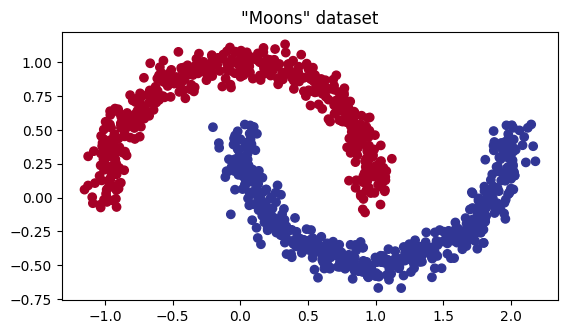

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.title('"Moons" dataset')
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons, cmap=plt.cm.RdYlBu)
plt.gca().set_aspect('equal')

In [5]:
from sklearn.model_selection import train_test_split

X_moons, y_moons = map(                                 # convert from numpy array to torch tensor
    lambda a: torch.from_numpy(a).type(torch.float),
    (X_moons, y_moons))

(X_train, X_test,
 y_train, y_test) = train_test_split(X_moons,           # split into train and test datasets
                                     y_moons,
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [6]:
from torch import nn

torch.manual_seed(RANDOM_SEED)                          # set random seed

# Inherit from nn.Module to make a model capable of fitting the moon data
class MoonModelV0(nn.Module):
    def __init__(self,
                hidden_layers:int=2,
                units:int=16,
                use_nonlinear:bool=True,
                *args, **kwargs) -> None:
        """ Initializes a binary-class classification mode version 0
        
        Args:
            hidden_layers: (int) number of hidden layers (excluding in and out layers)
            units: (int) number of hidden units per layer (default: 16)
            use_nonlinear: (bool) whether to include non-linear activation functions

        Returns:
            MoonModelV0 object instance
        """
        # validate inputs
        assert hidden_layers >= 0, "The number of layers must be >= 0"
        assert units >= 1, "The number of hidden units must be >= 1"
        
        super().__init__(*args, **kwargs)

        layer_stack = [nn.Linear(2, units),             # linear layer
                    nn.ReLU(),                          # Rectified Linear Unit (non-linear activation)
                    *[nn.Linear(units, units),
                    nn.ReLU()] * hidden_layers,
                    nn.Linear(units, 1)]

        self.layer_stack = nn.Sequential(               # nn layer stack
            *layer_stack[::(1 if use_nonlinear else 2)])
            
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """Forward pass of the MoonModelV0 binary classification mode
        Args:
            x: (torch.Tensor) binary dataset
            
        Returns:
            logits: (torch.Tensor) prediction logits"""
        return self.layer_stack(x)

# Instantiate the model
model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [7]:
LEARNING_RATE = 0.1

# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()                        # Binary Cross Entropy loss function

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model_0.parameters(),# Stochastic Gradient Descent optimizer
                            lr=LEARNING_RATE)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuracy, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [8]:
# What's coming out of our model?

# y_logits (raw outputs of model)
y_logits = model_0(X_train.to(device))
print(f"y_logits:\n{y_logits[:5]}")

# Prediction probabilities
y_pred_prob = torch.sigmoid(y_logits)
print(f"Pred probs:\n{y_pred_prob[:5]}")

# Prediction labels
y_pred = torch.round(y_pred_prob)
print(f"Pred labels:\n{y_pred[:5]}")

y_logits:
tensor([[-0.0941],
        [-0.1011],
        [-0.0988],
        [-0.0991],
        [-0.1004]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.4765],
        [0.4748],
        [0.4753],
        [0.4752],
        [0.4749]], grad_fn=<SliceBackward0>)
Pred labels:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)


In [9]:
# Let's calculate the accuracy using accuracy from TorchMetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="binary",                    # binary classification accuracy function
                  num_classes=2).to(device)             # send accuracy function to device
acc_fn

BinaryAccuracy()

In [10]:
import numpy as np

# Setup epochs
EPOCHS = 1000

# Send data to the device
X_train, X_test, y_train, y_test = map(
    lambda a: a.to(device), 
    (X_train, X_test, y_train, y_test))

losses_train, losses_test = [np.zeros((EPOCHS, 1))]*2

# Loop through the data
for epoch in range(EPOCHS):                             # training loop
    ### Training
    model_0.train()                                     # set to training mode

    # 1. Forward pass (logits output)
    y_logits = model_0(X_train).squeeze()               # prediction logits
    
    # Turn logits into prediction probabilities
    y_pred_prob = torch.sigmoid(y_logits)               # prediction probabilities

    # Turn prediction probabilities into prediction labels
    y_pred = torch.round(y_pred_prob)                   # prediction labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)                   # compare model raw outputs to desired model outputs
    losses_train[epoch] = float(loss)                   # store loss

    # Calculate the accuracy
    acc = acc_fn(y_pred, y_train.int())                 # compare pred labels (not logits) with actual labels

    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (perform back-propagation)
    # https://brilliant.org/wiki/backpropagation/
    loss.backward()

    # 5. Step the optimizer (gradient descent)
    # https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21
    optimizer.step()

    ### Testing
    model_0.eval() 
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        test_logits = model_0(X_test).squeeze()         # test prediction logits

        # Turn the test logits into prediction labels
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)        # test loss
        losses_test[epoch] = test_loss                  # store loss
        test_acc = acc_fn(test_pred, y_test)            # test accuracy

    # Print out what's happening every 10th of epochs
    if epoch % (EPOCHS/10) == 0:
        print(f"epoch: {epoch}, " + 
              f"loss: {loss:.4f}, "+
              f"acc {acc:.2f}, "+
              f"test loss: {test_loss:.4f}, "+
              f"test acc {test_acc:.2f}, ")

epoch: 0, loss: 0.6940, acc 0.50, test loss: 0.6929, test acc 0.50, 
epoch: 100, loss: 0.3027, acc 0.86, test loss: 0.3082, test acc 0.86, 
epoch: 200, loss: 0.2361, acc 0.89, test loss: 0.2317, test acc 0.89, 
epoch: 300, loss: 0.2027, acc 0.91, test loss: 0.1996, test acc 0.90, 
epoch: 400, loss: 0.1519, acc 0.93, test loss: 0.1488, test acc 0.94, 
epoch: 500, loss: 0.0793, acc 0.98, test loss: 0.0728, test acc 0.98, 
epoch: 600, loss: 0.0333, acc 1.00, test loss: 0.0280, test acc 1.00, 
epoch: 700, loss: 0.0169, acc 1.00, test loss: 0.0135, test acc 1.00, 
epoch: 800, loss: 0.0105, acc 1.00, test loss: 0.0082, test acc 1.00, 
epoch: 900, loss: 0.0074, acc 1.00, test loss: 0.0056, test acc 1.00, 


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [11]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

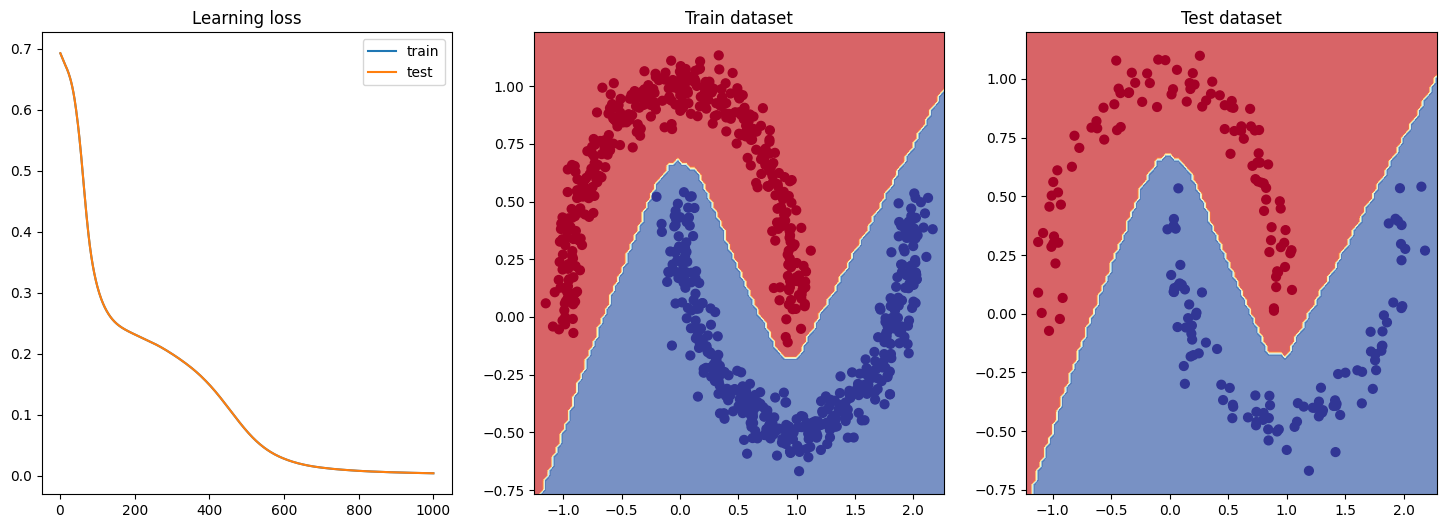

In [12]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title("Learning loss")
plt.plot(np.arange(EPOCHS)+1,
         np.hstack([losses_train, losses_test]),
         label=["train", "test"])
plt.legend()

plt.subplot(1,3,2)
plt.title("Train dataset")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,3,3)
plt.title("Test dataset")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [13]:
# Create a straight line tensor
line = torch.linspace(-5, 5, 50)

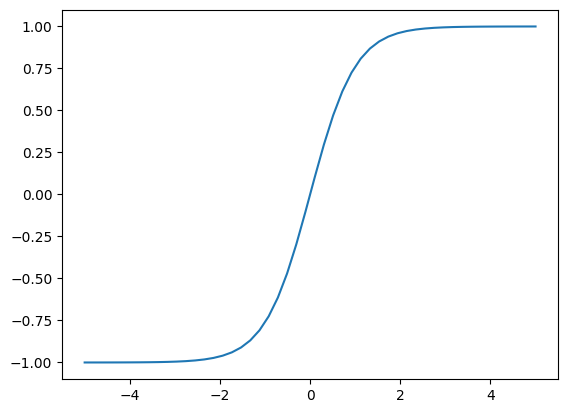

In [14]:
# Test torch.tanh() on the tensor and plot it
tanh_torch = torch.tanh(line)

plt.plot(line, tanh_torch)

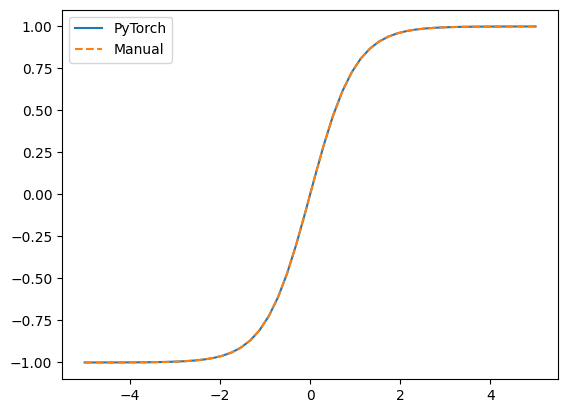

In [15]:
# Replicate torch.tanh() and plot it
tanh_manual = (torch.exp(line) - torch.exp(-line)) / (torch.exp(line) + torch.exp(-line))
plt.plot(line, tanh_torch, label="PyTorch")
plt.plot(line, tanh_manual, '--', label="Manual")
plt.legend()

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

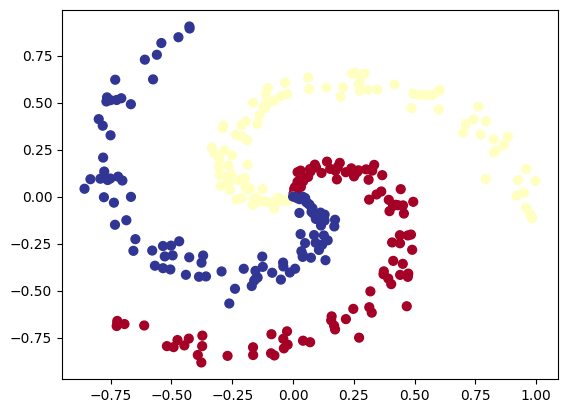

In [16]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [17]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits

(X_train, X_test,
 y_train, y_test) = train_test_split(X,                 # split into train and test datasets
                                     y,
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_SEED)


In [18]:
# Let's calculate the accuracy using accuracy from TorchMetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass",                    # binary classification accuracy function
                  num_classes=K).to(device)             # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [19]:
# Create model by subclassing nn.Module

class SpiralModelV0(nn.Module):
    def __init__(self,
                in_features:int=2,
                out_features:int=3,
                hidden_layers:int=2,
                units:int=16,
                use_nonlinear:bool=True,
                *args, **kwargs) -> None:
        """ Initializes a binary-class classification mode version 0
        
        Args:
            in_features: (int) number of input features (default: 2)
            out_features: (int) number of output features (default: 3)
            hidden_layers: (int) number of hidden layers (excluding in and out layers)
            units: (int) number of hidden units per layer (default: 16)
            use_nonlinear: (bool) whether to include non-linear activation functions

        Returns:
            SpiralModelV0 object instance
        """
        # validate inputs
        assert hidden_layers >= 0, "The number of layers must be >= 0"
        assert units >= 1, "The number of hidden units must be >= 1"
        
        super().__init__(*args, **kwargs)

        layer_stack = [nn.Linear(in_features, units),   # linear layer
                    nn.ReLU(),                          # Rectified Linear Unit (non-linear activation)
                    *[nn.Linear(units, units),
                    nn.ReLU()] * hidden_layers,
                    nn.Linear(units, out_features)]

        self.layer_stack = nn.Sequential(               # nn layer stack
            *layer_stack[::(1 if use_nonlinear else 2)])
            
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """Forward pass of the MoonModelV0 binary classification mode
        Args:
            x: (torch.Tensor) binary dataset
            
        Returns:
            logits: (torch.Tensor) prediction logits"""
        return self.layer_stack(x)


# Instantiate model and send it to device
model_1 = SpiralModelV0(out_features=K).to(device)
model_1


SpiralModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [20]:
# Setup data to be device agnostic
X_train, X_test, y_train, y_test = map(                 # send data to device
    lambda a: a.to(device),
    (X_train, X_test, y_train, y_test))

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
y_logits = model_1(X_train)
print(y_logits[:10])

print("Pred probs:")
y_pred_prob = torch.softmax(y_logits, dim=1)
print(y_pred_prob[:10])

print("Pred labels:")
y_pred = torch.argmax(y_pred_prob, dim=1)
print(y_pred[:10])

Logits:
tensor([[-0.1474, -0.0095,  0.0086],
        [-0.1629, -0.0127, -0.0079],
        [-0.1316, -0.0069,  0.0307],
        [-0.1437,  0.0058,  0.0174],
        [-0.1369,  0.0080,  0.0445],
        [-0.1311, -0.0042,  0.0290],
        [-0.1310, -0.0050,  0.0316],
        [-0.1437,  0.0014,  0.0222],
        [-0.1499, -0.0093,  0.0020],
        [-0.1438,  0.0062,  0.0176]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3015, 0.3461, 0.3524],
        [0.3003, 0.3490, 0.3507],
        [0.3022, 0.3423, 0.3555],
        [0.2997, 0.3481, 0.3522],
        [0.2981, 0.3446, 0.3574],
        [0.3022, 0.3431, 0.3547],
        [0.3020, 0.3426, 0.3554],
        [0.2997, 0.3465, 0.3538],
        [0.3017, 0.3472, 0.3512],
        [0.2997, 0.3482, 0.3522]], grad_fn=<SliceBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [21]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=LEARNING_RATE)

In [22]:
# Build a training loop for the model
losses_train, losses_test = [np.zeros((EPOCHS, 1))]*2

# Loop over data
for epoch in range(EPOCHS):

    ## Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1),
                          dim=1)

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    losses_train[epoch] = float(loss)
    acc = acc_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():

        # 1. Forward pass
        test_logits = model_1(X_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1),
                              dim=1)

        # 2. Calculate loss and acc
        test_loss = loss_fn(test_logits, y_test)
        losses_test[epoch] = test_loss
        test_acc = acc_fn(test_pred, y_test)
        
    # Print out what's happening every 10% of epochs
    if epoch % (EPOCHS/10) == 0:
        print(f"epoch: {epoch}, " + 
              f"loss: {loss:.4f}, "+
              f"acc {acc:.2f}, "+
              f"test loss: {test_loss:.4f}, "+
              f"test acc {test_acc:.2f}, ")

epoch: 0, loss: 1.0998, acc 0.35, test loss: 1.1042, test acc 0.40, 
epoch: 100, loss: 1.0626, acc 0.52, test loss: 1.0652, test acc 0.48, 
epoch: 200, loss: 0.9149, acc 0.55, test loss: 0.9137, test acc 0.50, 
epoch: 300, loss: 0.7904, acc 0.61, test loss: 0.7942, test acc 0.52, 
epoch: 400, loss: 0.5980, acc 0.65, test loss: 0.6217, test acc 0.62, 
epoch: 500, loss: 0.4264, acc 0.78, test loss: 0.4422, test acc 0.77, 
epoch: 600, loss: 0.2446, acc 0.94, test loss: 0.2393, test acc 0.95, 
epoch: 700, loss: 0.1373, acc 0.98, test loss: 0.1168, test acc 1.00, 
epoch: 800, loss: 0.0931, acc 0.99, test loss: 0.0673, test acc 1.00, 
epoch: 900, loss: 0.0720, acc 0.99, test loss: 0.0456, test acc 1.00, 


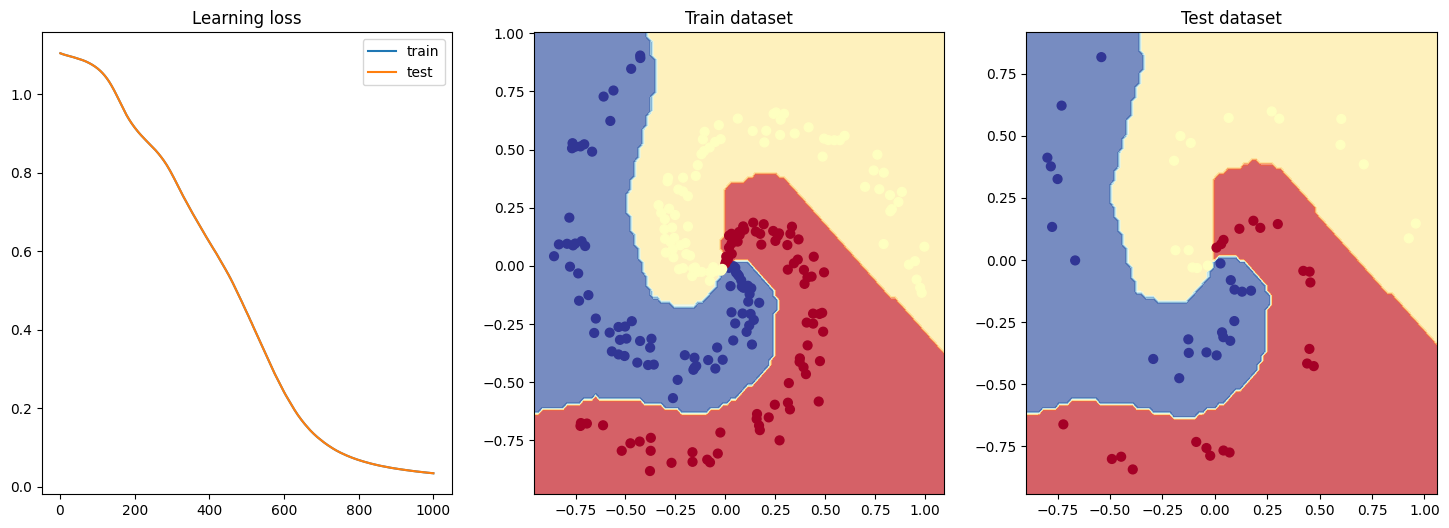

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title("Learning loss")
plt.plot(np.arange(EPOCHS)+1,
         np.hstack([losses_train, losses_test]),
         label=["train", "test"])
plt.legend()

plt.subplot(1,3,2)
plt.title("Train dataset")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,3,3)
plt.title("Test dataset")
plot_decision_boundary(model_1, X_test, y_test)